In [47]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import astropy.units as u
from astropy.coordinates import SkyCoord
def match(catalog_1, catalog_2):
    """
    匹配两个表
    :param catalog_1:
    :param catalog_2:
    :return:
    """
    sdss = SkyCoord(ra=catalog_1.ra*u.degree, dec=catalog_1.dec*u.degree)
    decals = SkyCoord(ra=catalog_2.ra*u.degree, dec=catalog_2.dec*u.degree)
    idx, d2d, d3d = sdss.match_to_catalog_sky(decals)
    # max_sep = 50 * 0.262 * u.arcsec
    max_sep = 25 * 0.262 * u.arcsec
    distance_idx = d2d < max_sep
    sdss_matches = catalog_1.iloc[distance_idx]
    matches = idx[distance_idx]
    decal_matches = catalog_2.iloc[matches]
    test = sdss_matches.loc[:].rename(columns={"ra":"new_ra", "dec":"new_dec"})
    test.insert(0, 'ID', range(len(test)))
    decal_matches.insert(0, 'ID', range(len(decal_matches)))
    new_df = pd.merge(test, decal_matches, how="inner", on=["ID"])
    return new_df.drop("ID", axis=1)

In [48]:
overlap = pd.read_csv("/data/renhaoye/overlap.csv", index_col=0)
# overlap = overlap.drop(columns=["raa", "decc", "ra", "dec"])
# overlap = overlap.rename(columns={"new_ra": "ra", "new_dec":"dec"})
overlap = overlap.iloc[:, :6]
overlap.head()

,ra,dec
0,249.264230,26.699189
1,248.282985,26.939269
2,224.595852,18.561191
3,178.445575,19.705478
4,126.765806,15.689960


In [49]:
# overlap.iloc[0, 0], overlap.iloc[0, 1], overlap.iloc[0, 2], overlap.iloc[0, 3], overlap.iloc[0, 7], overlap.iloc[0, 8]

In [50]:
out = os.listdir("/data/renhaoye/decals_2022/out_decals/scaled")
out_ra, out_dec = [], []
for i in tqdm(range(len(out))):
    t_ra, t_dec= float(out[i].split("_")[0]), float(out[i].split("_")[1])
    out_ra.append(t_ra)
    out_dec.append(t_dec)
out_dir = pd.DataFrame(list(zip(out_ra, out_dec)), columns=["ra", "dec"])
out_dir = match(out_dir, overlap)
out_dir = out_dir.drop(columns=["ra", "dec"])
out_dir = out_dir.rename(columns={"new_ra": "ra", "new_dec":"dec"})
out_dir.head()

100%|███████████████████████████████████████████████████████████████████████| 457118/457118 [00:00<00:00, 519267.49it/s]


,ra,dec
0,237.109902,7.142194
1,175.747588,13.083958
2,146.193908,13.539891
3,157.621458,7.187122
4,259.364040,28.355699


In [51]:
decals_dataset = pd.read_csv("/data/renhaoye/decals_2022/dataset_decals.csv", index_col=0)
decals_dataset = decals_dataset
out_dir_decals = match(decals_dataset, out_dir).drop(columns=["new_ra", "new_dec"])
out_dir = out_dir_decals.copy()
out_dir.head()

,redshift,iauname,petro_theta,petro_th50,petro_th90,elpetro_absmag_r,mag_r,label,func,ra,dec
0,0.124255,J100834.89+171737.7,7.509848,3.741791,7.589537,-21.779844,16.337662,0,train,152.145346,17.293814
1,0.082150,J132655.79+004152.9,8.000845,3.568215,9.373409,-21.083239,15.774693,0,train,201.731557,0.697321
2,0.082757,J132931.54+022706.1,6.938255,3.314074,7.589537,-20.806112,16.312237,0,train,202.380334,2.451056
3,0.108958,J142426.97+194258.8,5.898468,3.215826,6.651683,-21.494955,15.953232,0,train,216.110966,19.716753
4,0.118818,J151229.61+130229.1,6.575986,3.161087,8.704482,-22.158634,15.739040,0,train,228.123021,13.040405


In [52]:
merger = out_dir.query("label == 0")
round = out_dir.query("label == 1")
between = out_dir.query("label == 2")
cigar = out_dir.query("label == 3")
edgeOn = out_dir.query("label == 4")
noBar = out_dir.query("label == 5")
strongBar = out_dir.query("label == 6")
print(len(merger), len(round), len(between), len(cigar), len(edgeOn), len(noBar), len(strongBar))

634 7 6 11 29 228 5


In [53]:
from sklearn.model_selection import train_test_split
test_size = 0.4
merger_train, merger_valid = train_test_split(merger, test_size=test_size, random_state=1926)
round_train, round_valid = train_test_split(round, test_size=test_size, random_state=1926)
between_train, between_valid = train_test_split(between, test_size=test_size, random_state=1926)
cigar_train, cigar_valid = train_test_split(cigar, test_size=test_size, random_state=1926)
edgeOn_train, edgeOn_valid = train_test_split(edgeOn, test_size=test_size, random_state=1926)
noBar_train, noBar_valid = train_test_split(noBar, test_size=test_size, random_state=1926)
strongBar_train, strongBar_valid = train_test_split(strongBar, test_size=test_size, random_state=1926)
overlap_train = pd.concat([merger_train, round_train, between_train, cigar_train, edgeOn_train, noBar_train, strongBar_train])
overlap_valid = pd.concat([merger_valid, round_valid, between_valid, cigar_valid, edgeOn_valid, noBar_valid, strongBar_valid])

In [64]:
ROOT = "/data/renhaoye/decals_2022/"  # 根目录
sum = 0
with open("/data/renhaoye/decals_2022/dataset_txt/overlap_train.txt", "w") as w:  # 需要输入txt的特征文件名
    for i in tqdm(range(len(overlap_train))):  # 整个df的循环
        label = str(overlap_train.iloc[i].label)
        ra, dec = str(overlap_train.iloc[i].ra), str(overlap_train.iloc[i].dec),   # 先拿坐标和标签，这一步仅适用于decals的，sdss匹配的不可以
        if os.path.exists("/data/renhaoye/decals_2022/out_decals/scaled/" + ra + "_" + dec + "_0.262_grz_.fits"):
            w.write("/data/renhaoye/decals_2022/out_decals/scaled/" + ra + "_" + dec + "_0.262_grz_.fits " + str(label)[0] +"\n")
        else:
            sum += 1
print(sum)
sum = 0
with open("/data/renhaoye/decals_2022/dataset_txt/overlap_valid.txt", "w") as w:  # 需要输入txt的特征文件名
    for i in tqdm(range(len(overlap_valid))):  # 整个df的循环
        label = str(overlap_valid.iloc[i].label)
        ra, dec = str(overlap_valid.iloc[i].ra), str(overlap_valid.iloc[i].dec)   # 先拿坐标和标签，这一步仅适用于decals的，sdss匹配的不可以
        # print("/data/renhaoye/decals_2022/out_decals/scaled/" + ra + "_" + dec + "_0.262_grz_.fits " + str(label)[0] +"\n")
        if os.path.exists("/data/renhaoye/decals_2022/out_decals/scaled/" + ra + "_" + dec + "_0.262_grz_.fits"):
            w.write("/data/renhaoye/decals_2022/out_decals/scaled/" + ra + "_" + dec + "_0.262_grz_.fits " + str(label)[0] +"\n")
        else:
            sum += 1
print(sum)

100%|███████████████████████████████████████████████████████████████████████████████| 549/549 [00:00<00:00, 2823.98it/s]


0


100%|███████████████████████████████████████████████████████████████████████████████| 371/371 [00:00<00:00, 2901.74it/s]

0


In [38]:
from astropy.io import fits
import pickle
def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)
def hwc2chw(img):
    ch1, ch2, ch3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return np.array((ch1, ch2, ch3))
def load_img(file):
    """
    加载图像，dat和fits均支持，不过仅支持CxHxW
    :param filename: 传入文件名，应当为CHW
    :return: 返回CHW的ndarray
    """
    if ".fits" in file:
        with fits.open(file) as hdul:
            return hdul[0].data.astype(np.float32)
    elif ".dat" in file:
        with open(file, "rb") as f:
            return pickle.load(f)
    else:
        raise TypeError

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
def show(df):
    files = []
    plt.figure(figsize=(10, 10))
    for i in range(len(df)):
        ra, dec = str(df.iloc[i].ra), str(df.iloc[i].dec)
        files.append("/data/renhaoye/decals_2022/out_decals/scaled/" + ra + "_" + dec + "_0.262_grz_.fits")
    for i in range(len(files)):
        img = load_img(files[i])
        plt.subplot(7, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(chw2hwc(img))
    plt.tight_layout()
    plt.show()

ValueError: num must be 1 <= num <= 70, not 71

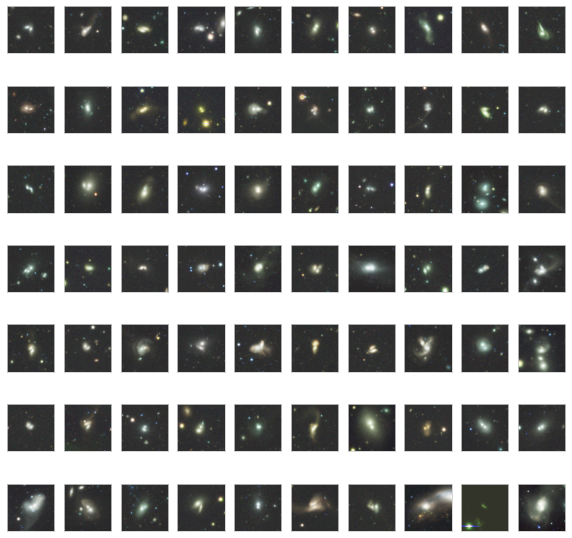

In [63]:
show(merger)

100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 59.69it/s]


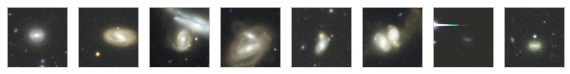

In [29]:
start = 70*10
show(overlap_valid.iloc[start:start+70, :])